# Задание

Пояснение к формату: login — логин асессора; tid — id оцениваемого задания (task id); Microtasks – количество микрозаданий в одном задании; assigned_ts — время резервирования системой задания для асессора; closed_ts — точное время завершения работы над заданием; разделитель — табуляция \t.

Задание может состоять из одного или несколько микрозаданий. Время резервирования задания (assigned_ts) указывает на тот момент, когда система назначила определенного асессора исполнителем этого задания. Этот момент может совпадать с временем начала работы асессора над заданием, а может и не совпадать (асессор может отойти выпить чаю, а потом приступить к заданию, асессор может выполнять предыдущее задание, в то время как за ним зарезервированы новые).

Предположим, что асессор за 30 секунд своего рабочего времени получает N рублей.

Какую оплату вы считаете справедливой для выполнения асессором одного микрозадания из этого файла? Опишите подробно все этапы вашего решения

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
# Функция numeral_data_processing проводит первичный анализ численных данных,
# выдает описание значений, гистограмму распределения всех данных и гистограмму
# распределения межквартильного разброса

def numeral_data_processing(df, column):
    
    print('\n\n',column)
    df[column].hist()
    plt.show()
    display(df[column].describe())
    empty = df[column].isnull().sum()
    print('Пустых значений в столбце: {:d}'.format(empty))
    
    print('\n\n',column,'IQR')
    median = df[column].median()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
          , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    df[column].loc[df[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist()
    plt.show()

In [3]:
asessors = pd.read_csv('data1.txt', sep='\t')
asessors.head(1)

,login,tid,Microtasks,assigned_ts,closed_ts
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01


Проверим данные на наличие пропусков

In [4]:
asessors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701827 entries, 0 to 701826
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   login        701827 non-null  object 
 1   tid          701827 non-null  float64
 2   Microtasks   701827 non-null  float64
 3   assigned_ts  701827 non-null  object 
 4   closed_ts    701827 non-null  object 
dtypes: float64(2), object(3)
memory usage: 26.8+ MB


Переведем дату в нужный формат str -> datatime

In [5]:
asessors.assigned_ts = pd.to_datetime(asessors.assigned_ts)
asessors.closed_ts = pd.to_datetime(asessors.closed_ts)

Добавим столбец времени выполнения задачи

In [6]:
asessors['time_ts'] = asessors.closed_ts - asessors.assigned_ts

Добавим столбцы среднего времени выполнения подзадачи, и среднего времени выполнения в секундах 

In [7]:
asessors['mean_microtask_time'] = asessors.time_ts / asessors.Microtasks
asessors['mean_microtask_time_seconds'] = asessors.mean_microtask_time.apply(lambda x: x.seconds)
asessors.head()

,login,tid,Microtasks,assigned_ts,closed_ts,time_ts,mean_microtask_time,mean_microtask_time_seconds
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01,0 days 01:03:22,0 days 00:15:50.500000,950
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29,0 days 00:17:59,0 days 00:17:59,1079
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10,0 days 01:08:39,0 days 00:17:09.750000,1029
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56,0 days 00:45:26,0 days 00:45:26,2726
4,login0,190562168.0,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50,0 days 00:46:08,0 days 00:23:04,1384


Посмотрим как отличается медианное и среднее время выполнения подзаданий сгруппированных по номеру задания

In [8]:
asessors.groupby('tid').mean_microtask_time_seconds.mean().mean()

459.7825248158393

In [9]:
asessors.groupby('tid').mean_microtask_time_seconds.median().median()

74.0

Видно, что они существенно отличаются, значит в данных могут быть выбросы



 mean_microtask_time_seconds


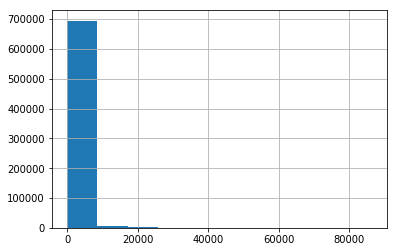

count    701827.000000
mean        515.157570
std        2849.413296
min           1.000000
25%          37.000000
50%          75.000000
75%         182.000000
max       86346.000000
Name: mean_microtask_time_seconds, dtype: float64

Пустых значений в столбце: 0


 mean_microtask_time_seconds IQR
25-й перцентиль: 37.0, 75-й перцентиль: 182.0, IQR: 145.0,  Границы выбросов: [-180.5, 399.5].


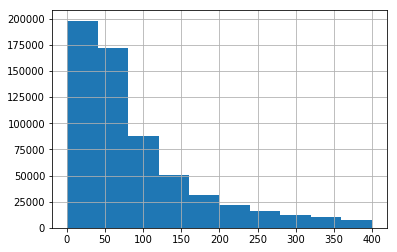

In [10]:
numeral_data_processing(asessors, 'mean_microtask_time_seconds')

Может быть какие-то задачи сложнее других?
посмотрим как выполняется задача, чаще всех попавшая в список долговыполняющихся

In [11]:
asessors[asessors.mean_microtask_time_seconds > 400].groupby('tid').login.count().sort_values()

tid
113958663.0     1
195383986.0     1
195383964.0     1
195383934.0     1
195383922.0     1
               ..
136579706.0    31
171470568.0    34
188676794.0    36
195476986.0    40
196322338.0    40
Name: login, Length: 85870, dtype: int64

In [12]:
asessors[asessors.tid == 196322338.0]

,login,tid,Microtasks,assigned_ts,closed_ts,time_ts,mean_microtask_time,mean_microtask_time_seconds
24452,login10,196322338.0,1.0,2017-05-27 14:32:38,2017-05-27 15:16:55,0 days 00:44:17,0 days 00:44:17,2657
24520,login11,196322338.0,1.0,2017-05-31 14:11:04,2017-05-31 14:16:55,0 days 00:05:51,0 days 00:05:51,351
28182,login16,196322338.0,1.0,2017-05-31 09:57:26,2017-05-31 10:00:56,0 days 00:03:30,0 days 00:03:30,210
29236,login16,196322338.0,1.0,2017-05-31 09:57:26,2017-05-31 10:00:56,0 days 00:03:30,0 days 00:03:30,210
34421,login21,196322338.0,1.0,2017-05-30 22:25:10,2017-05-30 22:25:26,0 days 00:00:16,0 days 00:00:16,16
...,...,...,...,...,...,...,...,...
654903,login715,196322338.0,1.0,2017-05-29 00:11:43,2017-05-29 00:24:33,0 days 00:12:50,0 days 00:12:50,770
668437,login729,196322338.0,1.0,2017-05-31 10:58:05,2017-05-31 10:59:32,0 days 00:01:27,0 days 00:01:27,87
691481,login750,196322338.0,1.0,2017-05-31 09:33:43,2017-05-31 09:36:56,0 days 00:03:13,0 days 00:03:13,193
692006,login753,196322338.0,1.0,2017-05-31 12:57:03,2017-06-01 03:09:52,0 days 14:12:49,0 days 14:12:49,51169


Судя по тому, что данная задача может выполняться быстро - дело в пользователях

Отсортируем пользователей, если среднее время выполнения подзадач отличается в большую сторону от медианного времени выполнения всех подзадач, то не будем учитывать данного пользователя в оценке

In [13]:
mean_per_user = asessors.groupby('login').mean_microtask_time_seconds.mean()
median_user_time = asessors.groupby('login').mean_microtask_time_seconds.mean().median()
IQR = mean_per_user.quantile(0.75) - mean_per_user.quantile(0.25)

In [14]:
good_users_1 = mean_per_user[mean_per_user <= (median_user_time + 1.5 * IQR)].keys() #Вариант с выявлением выбросов по принципу межквартильного разброса
good_users_2 = mean_per_user[mean_per_user <= (median_user_time)].keys() #Вариант с выявлением выбросов, как превышение медианного значения
asessors = asessors[asessors.login.isin(good_users_2)]

In [21]:
fair_pay = round(asessors.groupby('tid').mean_microtask_time_seconds.mean().median())*1.5

In [23]:
fair_pay

88.5